# <span style="color:#2595bc">Dynamic Programming</span>

Dynamic Programming(DP) refers to a collection of methods that can be used to compute optimal policies <span style="color:#f31818">given a perfect model of the enviroment</span>. The important assumption here is that we have a perfect knowledge of the model of the environment, ie how the environment works.

As earlier, assume that the environment is a finite MDP with its state, action, and reward sets, $\mathscr S$, $\mathscr A(s)$, and $\mathscr R$ and its transition dynamics are given by a set of probabilities $p(s',r|s,a)$ 

The key idea of DP, and of reinforcement learning generally, is the use of value functions to organize and structure the search for good policies.



<img src="images/1.png"></img>

<img src="images/2.png"></img>

<img src="images/3.png"></img>

In [1]:
import numpy as np
import os
import inspect
%matplotlib inline
import math
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

from utils import plotting

In [2]:

class gridworld:
    def __init__(self,dims,movementReward,terminalStates,gamma=1):
        self.dims = dims
        self.movementReward = movementReward
        self.terminalStates = terminalStates
        self.stateValues = np.zeros([dims,dims])
        self.gamma = gamma
        
class policyEval(gridworld):
    def __init__(self,prob=[.25,.25,.25,.25],dims=4,movementReward=-1,terminalStates = [[0,0],[3,3]]):
        assert not any(n < 0 for n in prob), 'probabilities are always non-negative dammit!'
        assert np.sum(prob)==1,'sum is not 1'
        
        super(policyEval,self).__init__(dims,movementReward,terminalStates)
        #self.currentValues = np.zeros([dims,dims])
        self.action_prob = {'UP':prob[0],'DOWN':prob[1],'LEFT':prob[2],'RIGHT':prob[3]}
        
    
   
    def getNextState(self,currentState,action,dims):
        if action == 'UP':
            nextState = (currentState[0]-1,currentState[1])
        if action == 'DOWN':
            nextState = (currentState[0]+1,currentState[1])
        if action == 'LEFT':
            nextState = (currentState[0],currentState[1]-1)
        if action == 'RIGHT':
            nextState = (currentState[0],currentState[1]+1)
        nextState = (max(nextState[0],0),max(nextState[1],0))
        nextState = (min(nextState[0],dims-1),min(nextState[1],dims-1))
        return nextState
    
    
    def evaluate(self):
        theta = 1e-4
        
        while(1):
            for i in range(self.dims):
                for j in range(self.dims):
                    if [i,j] not in self.terminalStates:
                        newValue = 0
                        for action in self.action_prob.keys():
                            nextState = self.getNextState((i,j),action,self.dims)
                            newValue += self.action_prob[action]*(self.movementReward + self.gamma*self.stateValues[nextState[0]][nextState[1]])
                        
                        if abs(self.stateValues[i][j] - newValue) < theta:
                            self.stateValues[i][j] = newValue
                            return self.stateValues
                        self.stateValues[i][j] = newValue
                        
    
                    
                
        
        

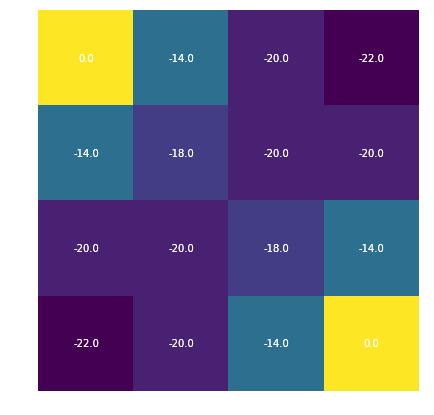

In [3]:
uniformDistributionPolicy = policyEval()
plotting.plot_gridworld_values(uniformDistributionPolicy.evaluate())



## <span style="color:#2595bc">Policy Improvement</span>
One of the main reasons why we evaluate the given policy at hand or find state values is to know whether we can improve our current policy. 

How can we get a better policy from the given one ? Remember State-Action Values ($Q(s,a)$) from earlier notebook? They were the expected rewards after choosing action a from state $s$.
$$q_{\pi}(s,a) = \mathbb E_{\pi}\bigr[ R_{t+1} + \gamma v_{\pi}(S_{t+1}) | S_t = s, A_t = a \bigl]$$
$$=\sum_{s',r}p(s',r|s,a)\bigl[ r+\gamma v_{\pi}(s')\bigl]$$

What if we tweak our current policy $\pi$ such that after a particular state $s$, we choose a particular action $a$ regardless what the old policy said and for the further states we follow the same old policy $\pi$, but only if the $Q(s,a)>V_{\pi}(s)$? That is we expect to get better rewards choosing action $a$ at that state $s$ than following policy $\pi$. The choice of $a$ clearly, should be <span style="color:#f31818">greedy</span>

In other words the improved policy $\pi '(s)$ would be - 
<img src="images/policyimprovement.png"></img>

where argmax$_a$ denotes the value of $a$ at which the expression that follows is maximized.

Also key to note that if two or more actions would yield the same $Q$ values at a particular state, equal probability can be assigned to each of them to be chosen. 

Let's see what the greedy policy for the value functions we got above would look like

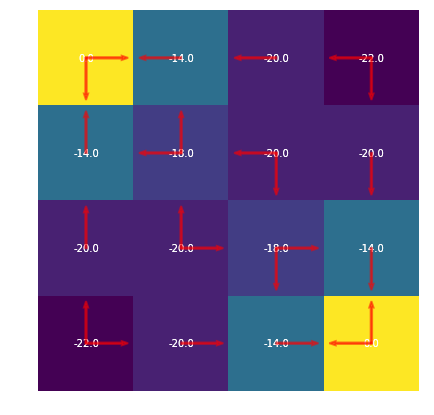

In [4]:
plotting.plot_gridworld_policy(uniformDistributionPolicy.evaluate())

The below diagrams show the value and greedy policy with increasing sweeps of iteration. It is key to note that <b>optimal policy is achieved well before the convergence</b> of value function. In this particular case we get the optimal policy in our third sweep itself. So inorder to get to the optimal policy it is not necessary to always iterate till convergence. Keep this fact in mind
<img src="images/policyimpchanging.png"></img>

What if we evaluate a policy where instead of uniform probability, the chances of moving in vertical directions is more, ie move up or down? How will the optimal policy change ? Can you guess ? 

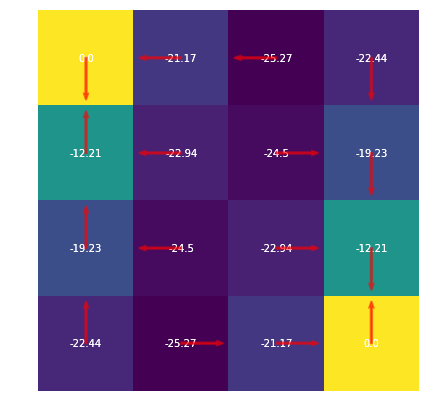

In [5]:
NonUniformDistributionPolicy = policyEval(prob=[.4,.4,.1,.1])
plotting.plot_gridworld_policy(NonUniformDistributionPolicy.evaluate())


## <span style="color:#2595bc">Policy Iteration</span>

Once a policy, $\pi$, has been improved using $v_\pi$ to yield a better policy, $\pi'$ , we can then
compute $v_{\pi '}$ and improve it again to yield an even better $\pi ''$ . We can thus obtain a
sequence of monotonically improving policies and value functions:
<img src="images/iterationchain.png"></img>
where the arrows represent policy evaluations and impovement.

Because a finite MDP has only a finite number of policies, this process <span style="color:#f31818">must converge</span> to an optimal policy and optimal value function in a finite number of iterations. (If curious, look up the proof on your own)

This way of finding an optimal policy is called <b>policy iteration</b>. The complete algorithm is as below - 
<img src="images/iterationalgo.png"></img>

### <span style="color:#2595bc">Policy Iteration Example-Jack’s Car Rental</span>
Jack manages two locations for a nationwide
car rental company. Each day, some number of customers arrive at each location
to rent cars. If Jack has a car available, he rents it out and is credited \$10 by the
national company. If he is out of cars at that location, then the business is lost.
Cars become available for renting the day after they are returned. To help ensure
that cars are available where they are needed, Jack can move them between the two
locations overnight, at a cost of \$2 per car moved. We assume that the number of
cars requested and returned at each location are Poisson random variables, meaning
that the probability that the number is $n$ is $\dfrac{\lambda^n}{n!}e^{−\lambda}$ , where $\lambda$ is the expected number.
Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2
for returns. To simplify the problem slightly, we assume that there can be no more
than 20 cars at each location (any additional cars are returned to the nationwide
company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate
to be $\gamma$ = 0.9 and formulate this as a continuing finite MDP, where the time steps
are days, the state is the number of cars at each location at the end of the day, and
the actions are the net numbers of cars moved between the two locations overnight.

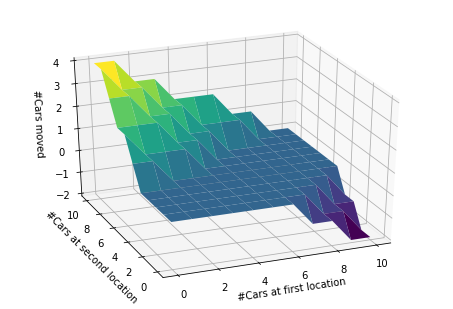

In [6]:
#Jacks Car rental 
availability_rent = 10 #10
moving_cost = 2 #2

mean_request_first = 3 #lambda #3
mean_request_second = 4 #lambda #4

mean_return_first = 3 #3
mean_return_second = 2 #2

max_cars = 10 #10
max_car_move = 5 #5

no_of_states = (max_cars+1)*(max_cars+1)
no_of_possible_actions = (2*max_car_move + 1) #11

actions = np.arange(-max_car_move,max_car_move+1,1)

discount = .9


# current policy
policy = np.zeros((max_cars + 1, max_cars + 1))

# current state value
state_value = np.zeros((max_cars + 1, max_cars + 1))


#create an array of dicts
next_states = []

#Calculation of poisson takes a lot of time


lookup_poisson = dict()
def poisson(n,lambd):
    global lookup_poisson
    if n-lambd>=6:
        return 0
    else:
        key = lambd*10 + n
        if key not in lookup_poisson.keys():
            lookup_poisson[key] = math.exp(-lambd) * pow(lambd, n) / math.factorial(n)
        return lookup_poisson[key]

def expected_return(state, action, state_value):
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= moving_cost * abs(action)

    # go through all possible rental requests
    for rent_request_first in range(0, mean_request_first+6):
        for rent_request_second in range(0, mean_request_second+6):
            # moving cars
            n_cars_in_first = int(min(state[0] - action, max_cars))
            n_cars_in_second = int(min(state[1] + action, max_cars))

            # valid rental requests should be less than actual # of cars
            cars_rented_in_first = min(n_cars_in_first, rent_request_first)
            cars_rented_in_second = min(n_cars_in_second, rent_request_second)

            # get credits for renting
            reward = (cars_rented_in_first + cars_rented_in_second) * availability_rent
            n_cars_in_first -= cars_rented_in_first
            n_cars_in_second -= cars_rented_in_second

            # probability for current combination of rental requests
            prob = poisson(rent_request_first, mean_request_first) * \
                         poisson(rent_request_second, mean_request_second)

            
           
            placeholder_n_cars_in_first  = n_cars_in_first
            placeholder_n_cars_in_second = n_cars_in_second
            placeholder_prob = prob
            
            for returned_cars_in_first in range(0, mean_return_first+6):
                for returned_cars_in_second in range(0, mean_request_second+6):
                    
                    temp_n_cars_in_first = n_cars_in_first
                    temp_n_cars_in_second = n_cars_in_second
                    temp_prob = prob
                    temp_n_cars_in_first = min(temp_n_cars_in_first + returned_cars_in_first, max_cars)
                    temp_n_cars_in_second= min(temp_n_cars_in_second + returned_cars_in_second, max_cars)
                    temp_prob = poisson(returned_cars_in_first, mean_return_first) * \
                                poisson(returned_cars_in_second, mean_return_second) * prob
                    returns += temp_prob * (reward + discount * state_value[temp_n_cars_in_first, temp_n_cars_in_second])
    return returns



new_state_value = np.zeros((max_cars + 1, max_cars + 1))
improve_policy = False
#policyImprovementInd = 0
counter = 0

while True:
    
    counter += 1
    print ('counter ',counter)
    if improve_policy == True:
        alpha = time.time()
        # start policy improvement
        
        
        print('Policy improvement')
        
        new_policy = np.zeros((max_cars + 1, max_cars + 1))
        for i in range(max_cars+1):
            for j in range(max_cars+1):
                action_returns = []
                # go through all actions and select the best one
                for action in actions:
                    if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                        action_returns.append(expected_return([i, j], action, state_value))
                    else:
                        action_returns.append(-float('inf'))
                best_action = np.argmax(action_returns)
                new_policy[i, j] = actions[best_action]

        # if policy is stable
        policyChanges = np.sum(new_policy != policy)
        print ('policyChanges-',policyChanges)
        
        beta = time.time()
        print("Policy improv took : ",beta-alpha)
        
        if policyChanges == 0:
            
            
            policy = new_policy
            break
        
        
        policy = new_policy
        improve_policy = False

    # start policy evaluation
    print('Policy Eval')
    for i in range(max_cars+1):
            for j in range(max_cars+1):
                new_state_value[i, j] = expected_return([i, j], policy[i, j], state_value)
    if np.sum(np.abs(new_state_value - state_value)) < 1e-4:
        state_value = new_state_value
        improve_policy = True
   
        continue
    state_value = new_state_value
  
    improve_policy = False
    

clear_output()


fig = plt.figure()
nx, ny = max_cars+1, max_cars+1
x = range(nx)
y = range(ny)
X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D


ax = Axes3D(fig)

#ax.plot_surface(X, Y, policy, cmap='viridis')
ax.set_xlabel('#Cars at first location')
ax.set_ylabel('#Cars at second location')
ax.set_zlabel('#Cars moved')
ax.view_init(azim = -112,elev = 30)

ax.plot_surface(X, Y, policy, cmap='viridis')


The below gif shows how the policy changes with each improvement.
<img src="images/Transition.gif"></img>

## <span style="color:#2595bc">Value Iteration</span>
One drawback to policy iteration is that each of its iterations involves policy evaluation, which may itself be a protracted iterative computation requiring multiple sweeps through the state set.

If policy evaluation is done iteratively, then convergence exactly to $v_{\pi}$ occurs only in the limit. Must we wait for exact convergence or can we stop short of that? Our experience during policy evaluation certainly suggests that it
may be possible to truncate policy evaluation. In that example, policy evaluation
iterations beyond the first three have no effect on the corresponding greedy policy.

In fact, the policy evaluation step of policy iteration can be truncated in several
ways without losing the convergence guarantees of policy iteration. One important
special case is when <span style="color:#f31818">policy evaluation is stopped after just one sweep (one backup
of each state)</span>. This algorithm is called <b>value iteration</b>. It can be written as a
particularly simple backup operation that combines the policy improvement and
truncated policy evaluation steps.

Given below is the descriptive algorithm for it
<img src="images/valueiteration.png"></img>

### <span style="color:#2595bc">Value Iteration-Example-Gambler's Problem</span>

A gambler has the opportunity to make bets
on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as
many dollars as he has staked on that flip; if it is tails, he loses his stake. The game
ends when the gambler wins by reaching his goal of \$100, or loses by running out of
money. On each flip, the gambler must decide what portion of his capital to stake,
in integer numbers of dollars. This problem can be formulated as an undiscounted,
episodic, finite MDP. The state is the gambler’s capital, $s \in {1, 2, . . . , 99}$ and the
actions are stakes, $a \in {0, 1, . . . , min(s, 100−s)}$. The reward is zero on all transitions
except those on which the gambler reaches his goal, when it is +1. The state-value
function then gives the probability of winning from each state. A policy is a mapping
from levels of capital to stakes. The optimal policy maximizes the probability of
reaching the goal. Let $p_h$ denote the probability of the coin coming up heads. If $p_h$
is known, then the entire problem is known and it can be solved, for instance, by
value iteration. Show the change in the value function over successive
sweeps of value iteration, and the final policy found, for the case of $p_h$ = 0.4.

Text(0,0.5,'Final Policy')

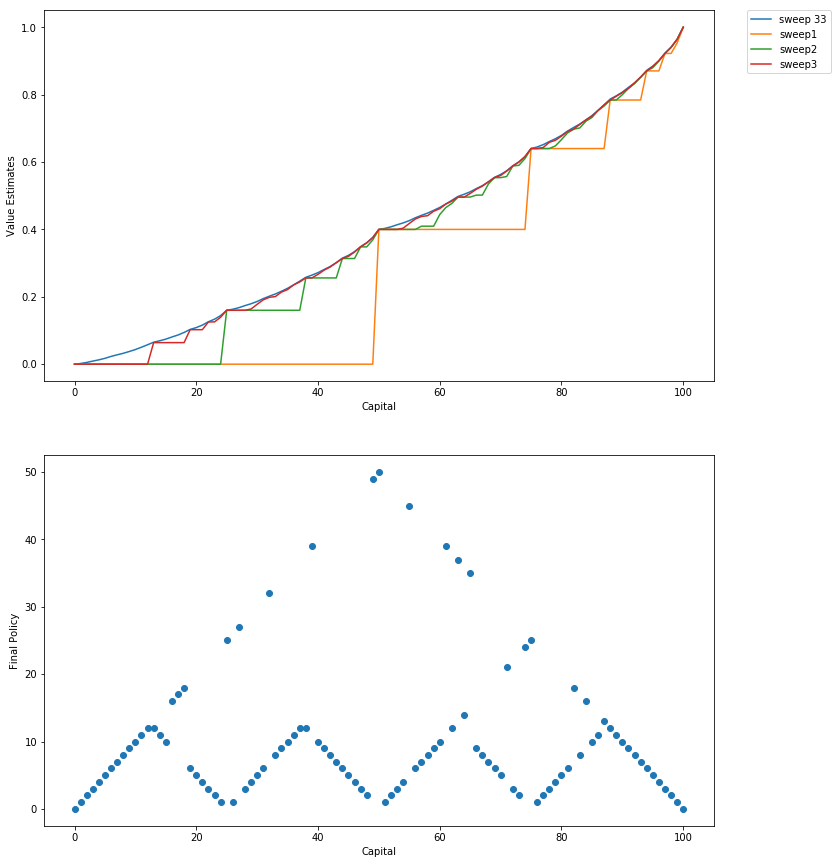

In [7]:

goal = 100

# all states
states = np.arange(goal + 1)

# probability of head"
prob_head = 0.4

# optimal policy
policy = np.zeros(goal + 1)

# state value

statevalue = np.zeros(goal+1)

statevalue[goal] = 1

#keep a record of state values, for plotting purposes
subsequent_state_values = []
counter = 0

# value iteration
while True:
    if counter in [1,2,3]:
        #keep a record of state value for few iterations
        subsequent_state_values.append(statevalue.copy())
        
   
    
    delta = 0.0
    
    for state in states[1:goal]:
        #possible actions for current state
        
        actions = np.arange(min(state, goal - state) + 1)
        
        returns = []
        for action in actions:
            returns.append(prob_head * statevalue[state + action] + (1 - prob_head) * statevalue[state - action])
        new_value = np.max(returns)
        
        delta += np.abs(statevalue[state] - new_value)
       
        statevalue[state] = new_value
        #print(state)
        #print((new_value), statevalue[state])
    
   
        
    counter += 1
    
    if delta < 1e-30:
       
        #terminate in case of convergence
        break

# calculate the final optimal policy
for state in states[1:goal]:
    actions = np.arange(1,min(state, goal - state) + 1)
    returns = []
    for action in actions:
        returns.append(prob_head * statevalue[state + action] + (1 - prob_head) * statevalue[state - action] )
    # due to tie, can't reproduce the optimal policy in book
    policy[state] = actions[np.argmax(returns)]

#Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))
axes[0].plot(statevalue, label="sweep "+str(counter))
axes[0].plot(subsequent_state_values[0],label="sweep1")
axes[0].plot(subsequent_state_values[1],label="sweep2")
axes[0].plot(subsequent_state_values[2],label="sweep3")

axes[0].set_xlabel("Capital")

axes[0].set_ylabel("Value Estimates")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

axes[1].scatter(states,policy)
axes[1].set_xlabel("Capital")

axes[1].set_ylabel("Final Policy")